In [132]:
# Imports needed in every section
import pandas as pd
import testing_scripts.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Section 1: Creating a labeled dataframe
This section involves reading in the resumes, filtering out entries whose CVs are too short, and creating positive and negative classes while filtering out all entries in neither class.

## From resumes parquet
This subsection assumes the existence of the resumes parquet file, processes, and exports the Labeled dataframe

In [46]:
# Read in the parquet
RESUMES_PARQUET_INPUT_FILENAME = "data/resumes.parquet"
raw_df = pd.read_parquet(RESUMES_PARQUET_INPUT_FILENAME, engine='pyarrow')  # raw dataframe

# Filter the dataframe by minimum cv length
MIN_CV_LENGTH = 1000
filtered_df = raw_df.loc[raw_df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

# Add a true label column based on the specified keywords
import testing_scripts.label_resumes
labeled_df = filtered_df.copy()
testing_scripts.label_resumes.add_true_label_column(labeled_df, constants.POSITIVE_POSITIONS, constants.POSITIVE_KEYWORDS, constants.NEGATIVE_POSITIONS, constants.NEGATIVE_KEYWORDS)

# Filter out entries whose true label is NA (i.e. belongs to neither class)
labeled_df = labeled_df[labeled_df["True Label"].notna()]

# # Export the labeled dataframe
# LABELED_DATAFRAME_OUTPUT_FILENAME = "data/labeled_df_PM vs UI.csv"
# labeled_df.to_csv(LABELED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the labeled_df.csv file already exists, run this instead to import the file

In [33]:
LABELED_DATAFRAME_INPUT_FILENAME = "data/labeled_df_PM vs UI.csv"
labeled_df = pd.read_csv(LABELED_DATAFRAME_INPUT_FILENAME)

## True label playground
This subsection contains some light code for examining the true label

In [6]:
# The size of the positive and negative classes
value_counts = labeled_df["True Label"].value_counts()
print(value_counts)

positiveClassSize = value_counts.get(constants.POSITIVE_LABEL, default=0)
negativeClassSize = value_counts.get(constants.NEGATIVE_LABEL, default=0)
print(f"Proportion of positives = {positiveClassSize / (positiveClassSize + negativeClassSize)}")

NameError: name 'labeled_df' is not defined

In [36]:
# Example positive entry
example_positive_entry = labeled_df.loc[labeled_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_cv: str = example_positive_entry.to_dict()["CV"]
print(f"Truncated positive CV:\n====================\n {example_positive_cv[:1000]}...")

Truncated positive CV:
 During my work in a role of a Client Success Manager, I was responsible for the large US-based accounts health and growth. I used to work on 3 - 4 large enterprise-level accounts in parallel with the total number of dedicated engineering teams 30 – 50 people.
I've generated a lot of ideas for improvements, participated in building up strong engineering teams and working out the processes and strategy for the clients, which have resulted in the account and team growth.
I had a chance to mentor and inspire many people, who have later become talented engineers and solution architects, and learn from them as well.
- Managing multiple accounts with different engagement models. 
- Managing all aspects of client relationships. 
- Analyzing client's business pain-points, assisting with the roadmap to help reaching out strategic goals. 
- Taking active part in the whole opportunity initiation process. Drafting Proposals and SOWs.
- Extending partnership with the existing

In [38]:
# Example negative entry 
example_negative_entry = labeled_df.loc[labeled_df["True Label"] == constants.NEGATIVE_LABEL].iloc[0]
exampleNegativeCV = example_negative_entry.to_dict()["CV"]
print(f"Truncated negative CV:\n====================\n {exampleNegativeCV[:1000]}")

Truncated negative CV:
 
•   Possession of Adobe Photoshop, Adobe-AI, skills of working with a graphic tablet;
•   UI/UX ;
•.  Figma, Zeplin, Sketch, MarvelApp, Invision;
•   2D graphics (understanding of pixel and vector graphics and their specifics);
•.  2D Design;
•.  3D Max;
•   Ability to work in different styles;
•   Ability to draw by hand;
•   Creation of design banners, layouts, logos, frameworks and prototypes for websites and mobile applications;
•   Testing of games;
•   Making presentations in Power Point;
Availability of portfolio;
Bug tracking systems and project management tools: Trello and Jira.
I'm self-motivated artist with a strong skills at game industry. I have more 5 years experience in game company, and now, I want to broaden my world with interesting projects, to share own experience and to acquire new skills and knowledge.
So, my goal is putting into practice somebody's dreams, in so doing, working with pleasure.
I would like to work at company with friendly t

In [40]:
# Look at negative labeled entries
# labeled_df.loc[labeled_df["True Label"] == constants.NEGATIVE_LABEL]

# Section 2: Marking samples for Experiments
This section involves marking samples in the labeled dataframe for experiments. This allows us to experiment on a few samples at a time, rather than all entries at once.

## From labeled_df
This subsection assumes the existence of the labeled_df object within this notebook, processes, and exports the Marked dataframe

In [41]:
# How many samples from each class we want to mark for experiments
NUM_POSITIVE_SAMPLES = 0
NUM_NEGATIVE_SAMPLES = 100

# Create a new column "Marked for Experiments" and deterministically mark 
# the first NUM_POSITIVE_SAMPLES positive entries and the first NUM_NEGATIVE_SAMPLES negative entries True and all others false
marked_df = labeled_df.copy()
marked_df["Marked for Experiments"] = False
positive_sample_indices = marked_df[marked_df["True Label"] == constants.POSITIVE_LABEL].index[:NUM_POSITIVE_SAMPLES]
negative_sample_indices = marked_df[marked_df["True Label"] == constants.NEGATIVE_LABEL].index[:NUM_NEGATIVE_SAMPLES]
marked_df.loc[positive_sample_indices, "Marked for Experiments"] = True
marked_df.loc[negative_sample_indices, "Marked for Experiments"] = True

# Export the marked dataframe
MARKED_DATAFRAME_OUTPUT_FILENAME = "data/marked_df_100 UI.csv"
marked_df.to_csv(MARKED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the marked_df.csv file already exists, run this instead to import the file

In [2]:
MARKED_DATAFRAME_INPUT_FILENAME = "data/marked_df_100 UI.csv"
marked_df = pd.read_csv(MARKED_DATAFRAME_INPUT_FILENAME)

## Mark playground
This subsection contains some light code for examining the true label

In [46]:
# The total number of marked entries (should match NUM_POSITIVE_SAMPLES + NUM_NEGATIVE_SAMPLES)
value_counts = marked_df["Marked for Experiments"].value_counts()
print(f"Number of samples = {value_counts.get(True)}")

Number of samples = 100


# Section 3: Generating tailored resumes
This section involves generating resumes tailored toward a specific job over the samples marked for experiments

## From marked_df
This subsection assumes the existence of the marked_df object within this notebook and generates modified resumes tailored toward the job specified in constants.py

In [5]:
# Add tailored resumes based on the job description using the chosen model
import testing_scripts.generate_resumes as generate_resumes
tailored_df = marked_df.copy()
generate_resumes.create_modified_resumes(tailored_df, job_name = constants.JOB_NAME, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME, verbose = True)

# Export the tailored dataframe
TAILORED_DATAFRAME_OUTPUT_FILENAME = "data/tailored_df_100 PM vs 100 UI.csv"
tailored_df.to_csv(TAILORED_DATAFRAME_OUTPUT_FILENAME)

Number of samples marked for experiments = 100
Generating a new tailored resume (0 generated so far)...
Generating a new tailored resume (1 generated so far)...
Generating a new tailored resume (2 generated so far)...
Generating a new tailored resume (3 generated so far)...
Generating a new tailored resume (4 generated so far)...
Generating a new tailored resume (5 generated so far)...
Generating a new tailored resume (6 generated so far)...
Generating a new tailored resume (7 generated so far)...
Generating a new tailored resume (8 generated so far)...
Generating a new tailored resume (9 generated so far)...
Generating a new tailored resume (10 generated so far)...
Generating a new tailored resume (11 generated so far)...
Generating a new tailored resume (12 generated so far)...
Generating a new tailored resume (13 generated so far)...
Generating a new tailored resume (14 generated so far)...
Generating a new tailored resume (15 generated so far)...
Generating a new tailored resume (1

## From import
If the tailored_df.csv file already exists, run this instead to import the file

In [22]:
TAILORED_DATAFRAME_INPUT_FILENAME = "data/tailored_df_100 PM vs 100 UI.csv"
tailored_df = pd.read_csv(TAILORED_DATAFRAME_INPUT_FILENAME)

## Tailored resumes playground
This subsection contains some light code for examining the tailored resumes

In [7]:
example_positive_entry = tailored_df[tailored_df["Marked for Experiments"] & tailored_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_CV = example_positive_entry["CV"]
example_positive_tailored_CV = example_positive_entry[constants.tailored_cv_name(model_name = constants.MODEL_NAME, job_name = constants.JOB_NAME)]

print(f"Truncated positive CV:\n====================\n {example_positive_CV[:750]}...")
print(f"\n\nTruncated positive tailored CV:\n====================\n {example_positive_tailored_CV[:750]}...")
# print(f"Example positive CV = {example_positive_cv}\n\n")

# example_tailored_positive_cv = generate_resumes.tailor_resume(example_positive_cv, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME)
# print(f"Example positive tailored CV = {example_tailored_positive_cv}")

IndexError: single positional indexer is out-of-bounds

In [9]:
example_negative_entry = tailored_df[tailored_df["Marked for Experiments"] & tailored_df["True Label"] == constants.NEGATIVE_LABEL].iloc[0]
example_negativeCV = example_negative_entry["CV"]
example_negative_tailored_CV = example_negative_entry[constants.tailored_CV_name(model_name = constants.MODEL_NAME, job_name = constants.JOB_NAME)]

print(f"Truncated negative CV:\n====================\n {example_negativeCV[:750]}...")
print(f"\n\nTruncated negative tailored CV:\n====================\n {example_negative_tailored_CV[:750]}...")
# print(f"Example positive CV = {example_positive_cv}\n\n")

# example_tailored_positive_cv = generate_resumes.tailor_resume(example_positive_cv, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME)
# print(f"Example positive tailored CV = {example_tailored_positive_cv}")

Truncated negative CV:
 
•   Possession of Adobe Photoshop, Adobe-AI, skills of working with a graphic tablet;
•   UI/UX ;
•.  Figma, Zeplin, Sketch, MarvelApp, Invision;
•   2D graphics (understanding of pixel and vector graphics and their specifics);
•.  2D Design;
•.  3D Max;
•   Ability to work in different styles;
•   Ability to draw by hand;
•   Creation of design banners, layouts, logos, frameworks and prototypes for websites and mobile applications;
•   Testing of games;
•   Making presentations in Power Point;
Availability of portfolio;
Bug tracking systems and project management tools: Trello and Jira.
I'm self-motivated artist with a strong skills at game industry. I have more 5 years experience in game company, and now, I want to broaden my...


Truncated negative tailored CV:
  **PROFESSIONAL PROFILE**

Self-motivated artist with over 5 years of experience in the game industry, seeking to broaden my skills and knowledge by working on exciting projects. Strong expertise in 

# Section 4: Scoring resumes
This section involves scoring the original and generated CVs

## From tailored_df
This subsection assumes the existence of the tailored_df object within this notebook and computes for both the original and generated CVs

In [13]:
# Add scores for both the original and generated CVs
import testing_scripts.score_resumes as score_resumes
scored_df = tailored_df.copy()
# scored_df = marked_df.copy()

# score_resumes.append_scores(scored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = "CV", verbose = True)
score_resumes.append_scores(scored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = constants.TAILORED_CV_NAME, verbose = True)

# Export the scored dataframe
SCORED_DATAFRAME_OUTPUT_FILENAME = "data/scored_df_100 tailored UI.csv"
scored_df.to_csv(SCORED_DATAFRAME_OUTPUT_FILENAME)

Number of samples marked for experiments = 100
Scoring a new resume (0 scored so far)...
Scoring a new resume (1 scored so far)...
Scoring a new resume (2 scored so far)...
Scoring a new resume (3 scored so far)...
Scoring a new resume (4 scored so far)...
Scoring a new resume (5 scored so far)...
Scoring a new resume (6 scored so far)...
Scoring a new resume (7 scored so far)...
Scoring a new resume (8 scored so far)...
Scoring a new resume (9 scored so far)...
Scoring a new resume (10 scored so far)...
Scoring a new resume (11 scored so far)...
Scoring a new resume (12 scored so far)...
Scoring a new resume (13 scored so far)...
Scoring a new resume (14 scored so far)...
Scoring a new resume (15 scored so far)...
Scoring a new resume (16 scored so far)...
Scoring a new resume (17 scored so far)...
Scoring a new resume (18 scored so far)...
Scoring a new resume (19 scored so far)...
Scoring a new resume (20 scored so far)...
Scoring a new resume (21 scored so far)...
Scoring a new res

## From import
If the scored_df.csv file already exists, run this instead to import the file

In [272]:
SCORED_DATAFRAME_INPUT_FILENAME = "data/scored_df_100 tailored UI.csv"
scored_df = pd.read_csv(SCORED_DATAFRAME_INPUT_FILENAME)

## Scored resumes playground
This subsection contains some light code for examining the resume scores

In [260]:
# # Extract original CV score series
# original_cv_scores: pd.Series = scored_df.loc[scored_df["CV Score"].notna(),"CV Score"]

# ORIGINAL_CV_SCORES_OUTPUT_FILENAME = "data/100 original UI CV scores.csv"
# original_cv_scores.to_csv(ORIGINAL_CV_SCORES_OUTPUT_FILENAME)

# Extract tailored CV score series
tailored_cv_scores: pd.Series = scored_df.loc[scored_df[constants.TAILORED_CV_NAME].notna(), f"{constants.TAILORED_CV_NAME} Score"]

TAILORED_CV_SCORES_OUTPUT_FILENAME = "data/100 tailored UI CV scores.csv"
tailored_cv_scores.to_csv(TAILORED_CV_SCORES_OUTPUT_FILENAME)

In [261]:
# Import each type
ORIGINAL_POSITIVE_SCORES_INPUT_FILENAME = "data/100 original PM CV scores.csv"
ORIGINAL_NEGATIVE_SCORES_INPUT_FILENAME = "data/100 original UI CV scores.csv"

original_positive_cv_scores: np.ndarray = pd.read_csv(ORIGINAL_POSITIVE_SCORES_INPUT_FILENAME)["CV Score"].values
original_negative_cv_scores: np.ndarray = pd.read_csv(ORIGINAL_NEGATIVE_SCORES_INPUT_FILENAME)["CV Score"].values

TAILORED_POSITIVE_SCORES_INPUT_FILENAME = "data/100 tailored PM CV scores.csv"
TAILORED_NEGATIVE_SCORES_INPUT_FILENAME = "data/100 tailored UI CV scores.csv"

tailored_positive_cv_scores: np.ndarray = pd.read_csv(TAILORED_POSITIVE_SCORES_INPUT_FILENAME)[f"{constants.TAILORED_CV_NAME} Score"].values
tailored_negative_cv_scores: np.ndarray = pd.read_csv(TAILORED_NEGATIVE_SCORES_INPUT_FILENAME)[f"{constants.TAILORED_CV_NAME} Score"].values

In [265]:
# positive_cv_scores = original_positive_cv_scores
# negative_cv_scores = original_negative_cv_scores
# positive_name: str = "Original PM"          # change me
# negative_name: str = "Original UI"          # change me

positive_cv_scores = tailored_positive_cv_scores
negative_cv_scores = tailored_negative_cv_scores
positive_name: str = "Tailored PM"          # change me
negative_name: str = "Tailored UI"          # change me

'''
Collect key statistics
'''
num_positive_scores = positive_cv_scores.size
num_negative_scores = negative_cv_scores.size
positive_proportion = num_positive_scores / (num_positive_scores + num_negative_scores)
negative_proportion = 1 - positive_proportion

positive_mean = positive_cv_scores.mean()
positive_std = positive_cv_scores.std()
negative_mean = negative_cv_scores.mean()
negative_std = negative_cv_scores.std()

from sklearn.metrics import roc_curve, auc
y_true = np.concatenate((np.ones(num_positive_scores), np.zeros(num_negative_scores)))
y_score = np.concatenate((positive_cv_scores, negative_cv_scores))
FPRs, TPRs, thresholds = roc_curve(y_true, y_score, drop_intermediate=False) 
roc_auc = auc(FPRs, TPRs)

accuracies = positive_proportion * TPRs + negative_proportion * (1 - FPRs)
optimal_index = np.argmax(accuracies)
optimal_accuracy = accuracies[optimal_index]
optimal_threshold = thresholds[optimal_index]
optimal_TPR = TPRs[optimal_index]
optimal_TNR = 1 - FPRs[optimal_index]

conservatively_optimal_index = np.argmax(np.where(FPRs == 0, TPRs, -np.NAN))      # mask elements where FPR is not 0 with negative infinity
conservatively_optimal_TPR = TPRs[conservatively_optimal_index]
conservatively_optimal_threshold = thresholds[conservatively_optimal_index]


Tailored PM score mean = 89.633, std = 3.392
Tailored UI score mean = 88.039, std = 3.421
Optimal accuracy = 0.665
	Optimal threshold = 90.33
	Optimal TPR = 0.57
	Optimal TNR = 0.76
Conservatively optimal TPR = 0.01
	Conservatively optimal threshold = 93.332
AUC = 0.675


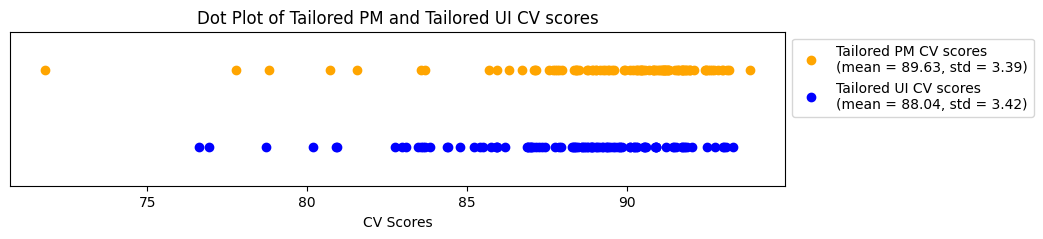

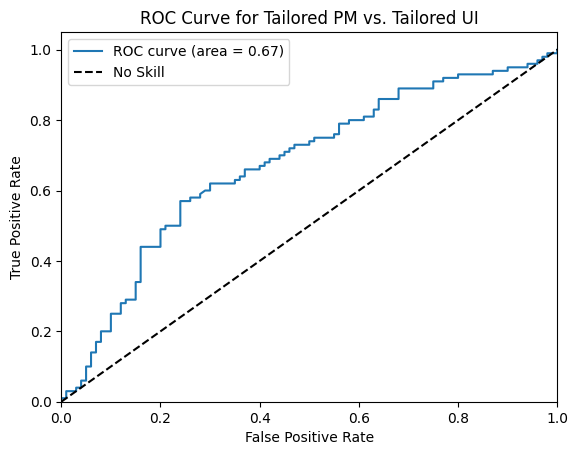

Saved to data/figures/100 tailored PM vs 100 tailored UI CV scores.png
Saved to data/figures/100 tailored PM vs 100 tailored UI CV ROC curve.png


In [266]:
'''
Print report
'''
save_to_file: bool = True                   # change me


uppercase_first = lambda string : string[0].upper() + string[1:]    # capitalizes first letter
lowercase_first = lambda string : string[0].lower() + string[1:]    # uncapitalizes first letter

# Print statistics
print(f"{positive_name} score mean = {positive_mean:.3f}, std = {positive_std:.3f}")
print(f"{negative_name} score mean = {negative_mean:.3f}, std = {negative_std:.3f}")

print(f"Optimal accuracy = {optimal_accuracy}\n\tOptimal threshold = {optimal_threshold}\n\tOptimal TPR = {optimal_TPR}\n\tOptimal TNR = {optimal_TNR}")
print(f"Conservatively optimal TPR = {conservatively_optimal_TPR}\n\tConservatively optimal threshold = {conservatively_optimal_threshold}")
print(f"AUC = {roc_auc:.3f}")


# Plot the distributions as a dot plot
distribution_figure, distribution_ax = plt.subplots(figsize=(10, 2))  # Create a figure and axis

positive_distribution_plot_label: str = f"{uppercase_first(positive_name)} CV scores\n(mean = {positive_mean:.2f}, std = {positive_std:.2f})"
negative_distribution_plot_label: str = f"{uppercase_first(negative_name)} CV scores\n(mean = {negative_mean:.2f}, std = {negative_std:.2f})"
distribution_ax.plot(positive_cv_scores, np.ones_like(positive_cv_scores), 'o', color='orange', label = positive_distribution_plot_label)  # Plot the positive scores
distribution_ax.plot(negative_cv_scores, np.zeros_like(negative_cv_scores), 'o', color='blue', label = negative_distribution_plot_label)   # Plot the negative scores

distribution_ax.set_ylim([-0.5, 1.5])
distribution_ax.set_yticks([])                                                                                                                           # Set y-ticks to be hidden to make it look like a 1-dimensional plot
distribution_ax.set_xlabel('CV Scores')
distribution_ax.set_title(f'Dot Plot of {uppercase_first(positive_name)} and {uppercase_first(negative_name)} CV scores')
distribution_ax.legend(bbox_to_anchor=(1, 1), loc='upper left')                             # Move legend outside plot
# distribution_figure.show()        # causes strange error
plt.show()


# Plot the ROC curve
ROC_figure, ROC_ax = plt.subplots()

ROC_ax .plot(FPRs, TPRs, label='ROC curve (area = %0.2f)' % roc_auc)
ROC_ax .plot([0, 1], [0, 1], 'k--', label='No Skill')
ROC_ax.set_xlim([0.0, 1.0])
ROC_ax.set_ylim([0.0, 1.05])
ROC_ax.set_xlabel('False Positive Rate')
ROC_ax.set_ylabel('True Positive Rate')
ROC_ax.set_title(f'ROC Curve for {uppercase_first(positive_name)} vs. {uppercase_first(negative_name)}')
ROC_ax.legend()
plt.show()

# Export the plots
if save_to_file:
    distribution_plot_filename  = f"data/figures/{num_positive_scores} {lowercase_first(positive_name)} vs {num_negative_scores} {lowercase_first(negative_name)} CV scores.png"
    ROC_plot_filename           = f"data/figures/{num_positive_scores} {lowercase_first(positive_name)} vs {num_negative_scores} {lowercase_first(negative_name)} CV ROC curve.png"

    distribution_figure.savefig(distribution_plot_filename, bbox_inches='tight')    # prevent from cropping off
    ROC_figure.savefig(ROC_plot_filename, bbox_inches='tight')                      # prevent from cropping off

    print(f"Saved to {distribution_plot_filename}")
    print(f"Saved to {ROC_plot_filename}")

In [269]:
# Find the threshold that maximizes TPR subject to FPR <= 0.2
semiconservatively_optimal_index = np.argmax(np.where(FPRs <= 0.2, TPRs, -np.NAN))      # mask elements where FPR is not 0 with negative infinity
semiconservatively_optimal_TPR = TPRs[semiconservatively_optimal_index]
semiconservatively_optimal_threshold = thresholds[semiconservatively_optimal_index]


In [279]:
semiconservatively_optimal_TPR 

0.49

In [271]:
semiconservatively_optimal_threshold

90.603

In [294]:
scored_df.loc[scored_df[f"{constants.TAILORED_CV_NAME} Score"] >= semiconservatively_optimal_threshold, f"CV"].iloc[10]

"\nI worked on the creation and implementation of ideas for branding tenders. I deveoped logos and outdoor advertising, actively worked with UNICEF projects. Also created presentations.I worked with the design of social media and together with the team we developed and designed ideas for outdoor advertising and social projects. Worked on design for the DARNITSA company's social media and its internal projects. I also led the social advertising project for Nova Poshta. Participated in creation of visual design of websites \r\nfor customers. Continued to work with UNICEF. Was making landing pages on Tilda and in Figma.\n"

In [285]:
f"{constants.TAILORED_CV_NAME}"

'A commitment to collaborative problem solving, agile thinking, and adaptability is essential. We are looking for a candidate who is able to balance a fast moving and changing environment with the ability to identify, investigate, and predict project risks Recruiting stages: HR interview, Tech interview **Core Responsibilities:** - Manage the full project life cycle including requirements gathering, creation of project plans and schedules, obtaining and managing resources, and facilitating project execution, deployment, and closure. - In cooperation with Technical Leads create and maintain comprehensive project documentation. - Manage Client expectations, monitor and increase CSAT level; - Plan, perform and implement process improvement initiatives. - Organize, lead, and facilitate cross-functional project teams. - Prepare weekly and monthly project status reports **What you need to Succeed:** - 1+ Year of dedicated Project Management in a production environment - Excellent organizatio